#### Imports

In [1]:
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import queue
import statistics 
from queue import PriorityQueue
from tqdm import tqdm 

# RQ1
----

### Build graph

In [2]:
G = nx.MultiDiGraph()
nodes = defaultdict(dict)

In [3]:
names = 'wiki-topcats-page-names.txt'
categories = 'wiki-topcats-categories.txt'
links = 'wikigraph_reduced.csv'

In [4]:
# multiplecat = {page_number = [list_of_categories]}

categories_list = defaultdict(list)
multiplecat = defaultdict(list)

with open(categories) as file:
    
    for line in file:
        line = line.split()
        cat = line[0].split(':')[1].strip(';')
        pages = list(map(int, line[1:len(line)]))
        
        if len(pages) >= 5000 and len(pages) <= 30000:
            categories_list[cat] = pages
            
            for i in range(len(pages)):
                multiplecat[pages[i]].append(cat)

In [5]:
# selecting at random one categories when a page belong to more than one

for page in multiplecat.keys():
    if len(multiplecat[page]) != 1:
        nodes[page]['category'] = multiplecat[page][random.randint(0,len(multiplecat[page])-1)]
    else:
        nodes[page]['category'] = multiplecat[page][0]

In [6]:
# nodes = {{page_number: {'name': page_name, 'category': page_category}}

with open(names) as file:
    for line in file:
        line = line.split()
        number = int(line[0])
        name = ' '.join(line[1:])
        if number in multiplecat.keys():
            nodes[number]['name'] = name

In [7]:
# adding nodes from the format 
# [(page_number, {'name': page_name, 'category': page_category})]

for key in nodes.keys():
    G.add_nodes_from([(int(key), nodes[key])])

In [8]:
with open(links) as file:
    file.readline()
    for line in file:
        line = line.split()
        origin = int(line[1])
        destination = int(line[2])
        if origin in nodes.keys() and destination in nodes.keys():
            G.add_edges_from([(origin,destination)])

In [9]:
#G.remove_nodes_from(list(nx.isolates(G)))
nx.info(G)

'Name: \nType: MultiDiGraph\nNumber of nodes: 149794\nNumber of edges: 483094\nAverage in degree:   3.2251\nAverage out degree:   3.2251'

----

The graph is directed because the web links are directional by definition. In addition we can check it by viewing that the number of unique origins is different from the number of unique destinations as we can see below.

In [10]:
df = pd.read_csv(links, sep='\t')
df.drop({'Unnamed: 0'},axis=1,inplace=True)
df.rename(columns={'0':'origin', '1':'destination'}, inplace=True)

In [11]:
df.head()

,origin,destination
0,95,1185516
1,108,1059989
2,108,1062426
3,108,1161925
4,134,541222


In [12]:
df.origin.nunique() == df.destination.nunique()

False

------

In [13]:
V = G.number_of_nodes()

In [14]:
E = G.number_of_edges()

In [15]:
print('We have a graph containing',V,'articles and',E,'hyperlinks.')

We have a graph containing 149794 articles and 483094 hyperlinks.


In [16]:
print('The average number of links per page is:', round(E/V,4))

The average number of links per page is: 3.2251


In [17]:
print('The graph density is',E/(V*(V-1)))

The graph density is 2.153008313619922e-05


A graph is dense if the number of edges is close to the maximal number of edges that it can have. For directed graph that number is $$ M^* = {2\cdot {|V| \choose 2}}$$ In other word the graph is dense if the ratio $|E|/M^*$ is close to 1. In our case we can affirm that the graph is sparse. 

-----
#### Nodes degree distribution

In [18]:
in_degrees = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]

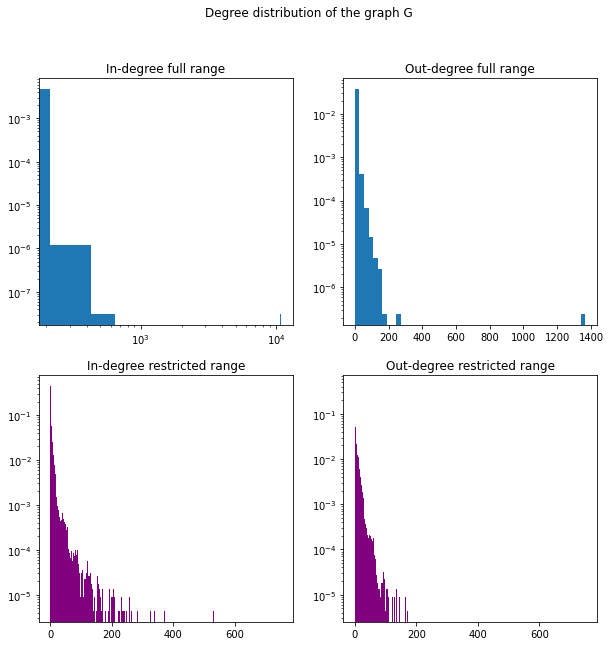

In [19]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
plt.rc('legend', fontsize=6)   
fig.suptitle('Degree distribution of the graph G')

axs[0,0].set_xscale('log')
axs[0,0].hist(in_degrees, log = True, density = True, bins = 50)
axs[0,0].set_title('In-degree full range')

axs[1,0].hist(in_degrees, log = True, density = True, bins = 500, 
            range=(0,750), color = 'purple')
axs[1,0].set_title('In-degree restricted range')

axs[0,1].hist(out_degrees, log = True, density = True, bins = 50)
axs[0,1].set_title('Out-degree full range')

axs[1,1].hist(out_degrees, log = True, density = True, bins = 500, 
            range=(0,750), color = 'purple')
axs[1,1].set_title('Out-degree restricted range')

plt.show()

We can see that the degree distribution has most of its value before 300, but also a long tail due to the outliers. 

# RQ2
-----

In [22]:
def RQ2(page, nr_clicks):
    l = []
    new_nodes = [page]
    for i in range(nr_clicks):
        a = list(df.loc[df["origin"].isin(new_nodes)]["destination"])
        l.extend(a)
        new_nodes = a
    return list(set(l))

In [23]:
RQ2(95,3)

[1595904,
 1182721,
 1061891,
 1067523,
 1060361,
 1075210,
 1062924,
 1058318,
 1058832,
 1061905,
 1065488,
 1184788,
 1057316,
 1053744,
 1060403,
 1060926,
 397380,
 1061966,
 1058392,
 1057884,
 1060445,
 1063517,
 1184864,
 1068139,
 1061483,
 823931,
 110209,
 1060995,
 1063559,
 1065608,
 1063050,
 1065616,
 1183891,
 1217697,
 1062563,
 943780,
 688300,
 1179311,
 1060529,
 1163441,
 1592499,
 1066682,
 1063101,
 1184448,
 1061060,
 1061573,
 1061574,
 1731279,
 1731281,
 1063123,
 1551064,
 358617,
 1062107,
 1060572,
 1062624,
 1185516,
 1061105,
 1062129,
 1063684,
 903941,
 1377543,
 1064715,
 1061132,
 1058061,
 1184017,
 1179925,
 1184022,
 1183515,
 1177884,
 1164575,
 1057056,
 1176356,
 1064744,
 1061675,
 1163564,
 1178930,
 1185078,
 1059127,
 1063738,
 1064265,
 1059658,
 1058123,
 1058641,
 1057618,
 1761109,
 1058645,
 1064280,
 1063257,
 1055075,
 1377636,
 1067876,
 1179495,
 1240445,
 1184640,
 757137,
 1061779,
 1163156,
 1062295,
 1164183,
 1061276,
 1054633

# RQ3
-----

In [18]:
print(', '.join(categories_list.keys()))

English_footballers, The_Football_League_players, Association_football_forwards, Association_football_midfielders, Association_football_defenders, Harvard_University_alumni, Major_League_Baseball_pitchers, Members_of_the_United_Kingdom_Parliament_for_English_constituencies, Indian_films, Year_of_death_missing, Rivers_of_Romania, Main_Belt_asteroids, Asteroids_named_for_people, English-language_films, American_films, American_television_actors, American_film_actors, Debut_albums, Black-and-white_films, Year_of_birth_missing, Place_of_birth_missing_(living_people)


In [102]:
def BFS(G,v):
    q = queue.LifoQueue()
    dist = dict()
    paths = defaultdict(list)
    
    visited = [v]
    dist[v] = 0
    paths[v].append(v)
    
    q.put(v)
    while not q.empty():
        v = q.get()
        for u in G.neighbors(v):
            if u not in visited:
                visited.append(u)
                dist[u] = dist[v] + 1
                paths[u] += paths[v] + [u]
                q.put(u)
                
    return dist, paths

In [20]:
def randomSubset(G, p):
    s = set()
    for node in G.nodes():
        a = random.random()
        if a <= p:
            s.add(node)
    return s

In [21]:
def categoryGraph(G,C):
    
    out = nx.MultiDiGraph()
    
    for node in G.nodes():
        cat = G.nodes[node]['category']
        if cat == C:
            out.add_nodes_from([(int(node), nodes[node])])
            
    new_edges = []
    for edge in G.edges():
        if edge[0] in out.nodes() or edge[1] in out.nodes():
            new_edges.append(edge)
    out.add_edges_from(new_edges)
    
    return out

In [22]:
def zero():
    return 0

In [23]:
def most_central_article(subset):
    d = defaultdict(zero)
    n_nodes = len(df)
    for edge in subset.edges():
        d[edge[1]] += 1
    out = max(d, key=d.get)
    return out

In [152]:
def RQ3(G,C,S=None):
    nG = categoryGraph(G,C)
    v = most_central_article(nG)
    
    # All shortest paths from v
    _, paths = BFS(nG,v)
    
    # If the set of pages is not given in input
    if S == None:
        S = set(random.sample(paths.keys(), 100))
        S.add(v)
    
    # Checking connectivity, if there is a node of S
    # there is a node of S that we cannot reach from v 
    # return 'Not possible'
    
    if not set(paths.keys()).issuperset(S):
        return 'Not possible'
    
    # Init spanning tree
    pathGraph = nx.DiGraph()
    for node in paths.keys():
        pathGraph.add_nodes_from([(int(node), nodes[node])]) #Maybe tuple not necessary
    
    for node in paths.keys():
        for i in range(len(paths[node])-1):
            pathGraph.add_edge(paths[node][i],paths[node][i+1])
    
    # Adding edges until we have a path
    for node in pathGraph:
        if len(pathGraph.out_edges(node)) == 0:
            try:
                new = random.choice(list(nG.out_edges(node)))
                pathGraph.add_edges_from([(new[0],new[1])])
            except:
                print('vicolo cieco')
    
    print('----------------')
    print('The approximated number of clicks is', pathGraph.number_of_edges())

In [153]:
RQ3(G,'Harvard_University_alumni', None)

vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco
vicolo cieco

# RQ4
----

In [137]:
def subGraph(G,C1,C2):
    nodes = []
    for i in G.nodes():
        cat = G.nodes[i]['category']
        if cat == C1 or cat == C2:
            nodes.append(i)
    out = G.subgraph(nodes) ## DA MODIFICARE
    return out.copy()

In [21]:
def contract(G, del_edge):
    to_keep = del_edge[1]
    to_delete =  del_edge[0]
    
    edges  = G.edges(to_delete)
 
    for edge in edges:
        if edge[1] != to_keep:
            #print('Adding inedges...')
            #print((edge[1], to_keep))
            G.add_edge(edge[1], to_keep)
            
    G.remove_node(to_delete)

In [22]:
def Karger(G, N = None):
    
    if N == None:
        n = len(G.nodes)
        N = n**2*np.log(n)
        
    results = []
    
    for i in range(int(N)):
        nG = G.to_undirected().copy()
    
        while nG.number_of_nodes() > 2:
            
            '''
            FOR DEBUG PURPOSES
            print(list(nG.edges()))
            nx.draw(nG, with_labels=True)
            plt.show()
            print('Removing edge:', deleted_edge)
            '''
            
            deleted_edge = random.choice(list(nG.edges()))
            contract(nG, deleted_edge)       

        results.append(len(list(nG.edges())))
        
    return min(results)

In [27]:
def RQ4(C1,C2):
    subG = subGraph(G,C1,C2)
    subG.remove_nodes_from(list(nx.isolates(subG)))
    
    try:

        if not nx.is_weakly_connected(subG):
            return 'The graph is not connected...'

        else:
            #out = 'The Min-Cut between' + C1 + 'and' + C2 + 'is' + str(nx.minimum_edge_cut(subG.to_undirected()))
            out = 'The Min-Cut between' + C1 + 'and' + C2 + 'is' + str(Karger(subG,1))
            return out

    except:
        return 'Some error occured, maybe the graph is empty'

In [23]:
C1 = 'The_Football_League_players' 
C2 = 'English_footballers'

In [28]:
RQ4(C1,C2)

'The graph is not connected...'

# RQ5
----

In [29]:
def ModifiedFW(G):
    n = G.number_of_nodes()
    dist = np.ones((n,n)) * np.inf
    np.fill_diagonal(dist, 0)
    
    # Init
    pred = np.ones((n,n)) * np.inf
    for i,j in G.edges():
        dist[i,j] = 1
        pred[i,j] = i
    
    for k in G:
        for i in G:
            for j in G:
                if dist[i,j] > dist[i,k] + dist[k,j]:
                    dist[i,j] = dist[i,k] + dist[k,j]
                    pred[i,j] = pred[k,j]

    return dist, pred

In [134]:
def Dijkstra(G, source):
    dist = dict()
    visited = set()
    
    for v in G:
        dist[v] = np.infty
    dist[source] = 0
    
    queue = PriorityQueue()    
    queue.put((0, source))
    
    while queue.qsize() != 0:
        cost, u = queue.get()
        visited.add(u)
        
        for v in G.neighbors(u):
            alt = dist[u] + 1
            if alt < dist[v]:
                dist[v] = alt
                visited.add(v)
                queue.put((dist[v],v))
                
    #dist = {k:v for k,v in dist.items() if v != np.infty}

    return dist

In [40]:
def RQ5(G, C):
    origins = [v for v in G if G.nodes[v]['category'] == C]
    scores = defaultdict(list)
    dist = dict()
    
    for node in origins:
        dist[node] = Dijkstra(G, node)
        #dist[node] = nx.single_source_dijkstra_path_length(G,node)
        
    
    for origin_node in dist.keys():
        for destination_node in dist[origin_node]:
            scores[G.nodes[destination_node]['category']].append(
                dist[origin_node][destination_node])
    
    scores = dict((k, statistics.median(v)) for k,v in scores.items())
    scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}
    return scores

In [42]:
RQ5(G,'Asteroids_named_for_people')

{'Main_Belt_asteroids': 5.0,
 'Asteroids_named_for_people': 6.0,
 'Harvard_University_alumni': 9,
 'American_television_actors': 9.0,
 'American_film_actors': 9.0,
 'English-language_films': 9.0,
 'American_films': 9.0,
 'Black-and-white_films': 9.0,
 'Year_of_birth_missing': 10,
 'Place_of_birth_missing_(living_people)': 10,
 'Members_of_the_United_Kingdom_Parliament_for_English_constituencies': 10.0,
 'Debut_albums': 10,
 'Year_of_death_missing': 11.0,
 'Major_League_Baseball_pitchers': 11.0,
 'Association_football_forwards': 12.0,
 'English_footballers': 12.0,
 'The_Football_League_players': 12,
 'Association_football_midfielders': 12,
 'Indian_films': 12.0,
 'Association_football_defenders': 13.0,
 'Rivers_of_Romania': 13.0}

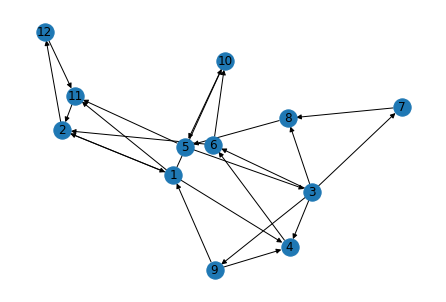

In [32]:
### KEEP FOR TESTING PURPOSES

g = nx.MultiDiGraph()
g.add_nodes_from([
    (1, {"category": "A"}),
    (2, {"category": "A"}),
    (3, {"category": "A"}),
    (4, {"category": "B"}),
    (5, {"category": "B"}),
    (6, {"category": "B"}),
    (7, {"category": "C"}),
    (8, {"category": "C"}),
    (9, {"category": "A"}),
    (10, {"category": "B"}),
    (11, {"category": "C"}),
    (12, {"category": "C"}),
])
g.add_edges_from([(1,2),(3,4),(2,1),(12,11),(8,5),
                 (5,3),(1,4),(9,4),(2,12),(5,11),
                 (9,1),(1,11),(3,8),(3,9),(11,2),
                 (10,5),(6,10),(1,10),(7,8),(6,2),
                 (3,6),(4,6),(3,7)])
nx.draw(g, with_labels= True)

# RQ6
---

#### 1. Create the new graph

In [10]:
remaining = list(categories_list.keys())

In [11]:
catG = nx.DiGraph()

In [12]:
i = 0
prova = dict()
for cat in remaining:
    catG.add_nodes_from([(i, {'category': cat})])
    prova[cat] = i
    i += 1

In [13]:
for cat in remaining:
    for node in categories_list[cat]:
        for edge in G.out_edges(node):
            origin_cat = G.nodes[edge[0]]['category']
            dest_cat = G.nodes[edge[1]]['category']
            if origin_cat != dest_cat:
                catG.add_edge(prova[origin_cat],prova[dest_cat])

#### 2. PageRank

In [43]:
def RQ6(G, alpha=0.15):
    A = nx.adjacency_matrix(G).toarray()
    sum_of_rows = A.sum(axis=1)
    A_norm = A / sum_of_rows[:, np.newaxis]  
    P = alpha * np.ones((len(A),len(A)))/len(A) + (1-alpha)*A_norm
    v = np.ones(len(A))/len(A)
    
    for i in range(10000):
        v = np.dot(v,P)
    
    results = dict()
    
    print('|------------------|')
    print('| PageRank results |')
    print('|------------------|')
    print()
    for i in range(len(v)):
        results[i] = round(v[i]*100,2)
            
    for el in sorted(results.items(), key=lambda item: item[1], reverse=True):
        print('Score:', el[1], 'Category:', catG.nodes[el[0]]['category'])
        
    return results

In [44]:
results = RQ6(catG)

|------------------|
| PageRank results |
|------------------|

Score: 7.32 Category: English-language_films
Score: 5.59 Category: Year_of_birth_missing
Score: 5.57 Category: Year_of_death_missing
Score: 5.57 Category: American_television_actors
Score: 5.57 Category: American_film_actors
Score: 5.56 Category: Place_of_birth_missing_(living_people)
Score: 5.32 Category: Association_football_forwards
Score: 5.26 Category: Harvard_University_alumni
Score: 5.12 Category: American_films
Score: 5.06 Category: Debut_albums
Score: 4.89 Category: Association_football_midfielders
Score: 4.88 Category: English_footballers
Score: 4.87 Category: Association_football_defenders
Score: 4.76 Category: Members_of_the_United_Kingdom_Parliament_for_English_constituencies
Score: 4.75 Category: Black-and-white_films
Score: 4.64 Category: The_Football_League_players
Score: 3.85 Category: Major_League_Baseball_pitchers
Score: 3.55 Category: Indian_films
Score: 3.22 Category: Main_Belt_asteroids
Score: 2.46 Ca

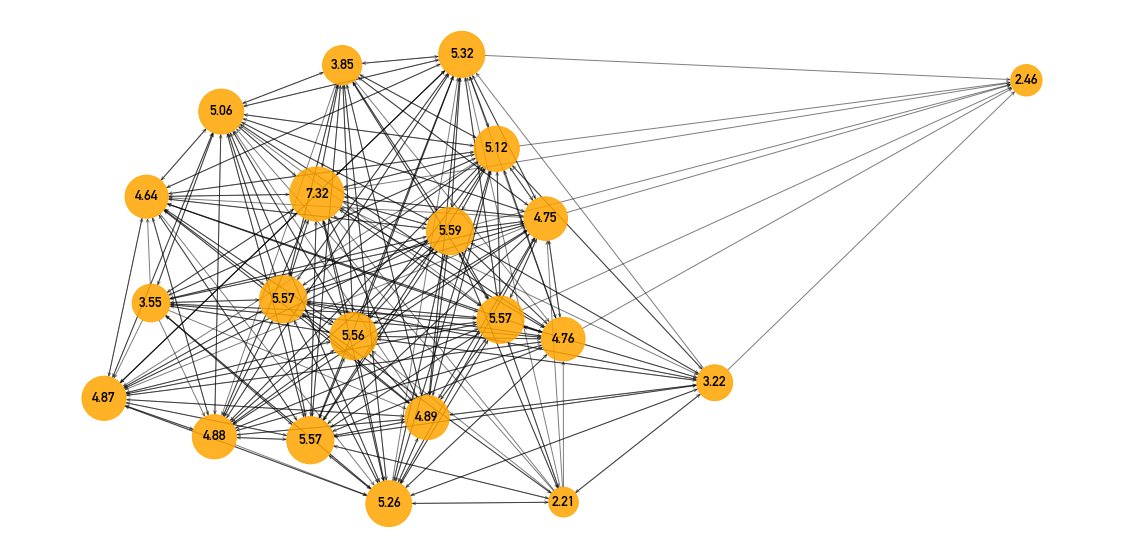

In [42]:
plt.figure(figsize=(20,10))
pos = nx.spring_layout(catG, seed=42)
d = dict(catG.degree)

node_sizes = [v * 400 for v in results.values()]
cmap = plt.cm.plasma

nodes = nx.draw_networkx_nodes(catG, 
                               pos, 
                               node_size=node_sizes, 
                               node_color="orange",
                               alpha=0.85)

edges = nx.draw_networkx_edges(catG,
                               pos,
                               node_size=node_sizes,
                               arrowstyle= "->",
                               arrowsize= 7,
                               width= 1,
                               alpha =0.5)

labels = nx.draw_networkx_labels(catG, 
                                 pos, 
                                 font_family='DIN Alternate',
                                 labels = results,
                                 font_size=14)
                                 

ax = plt.gca()
ax.set_axis_off()
plt.show()